In [1]:
import sys
print(sys.version)

3.10.4 (tags/v3.10.4:9d38120, Mar 23 2022, 23:13:41) [MSC v.1929 64 bit (AMD64)]


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

In [3]:
data = pd.read_csv("data_lite.csv")
data.head()

,name,salary,company_name,metro_station,description_list_items,company_address,rating,skills,description
0,Senior Go Developer,NaN,PointPay,Щукинская,"['Требуемый опыт работы', '', ':', '3–6 лет']","Москва, Щукинская, Авиационная улица, 72к1",Нет отзывов,"Golang, SQL, Kubernetes, Go, GRPС",PointPay – криптовалютная банковская экосистем...
1,Программист Python,NaN,LIFE PAY,NaN,[],NaN,"4,9","Git, Асинхронное программирование, Удаленная р...","LIFE PAY — это разработчик платежных, кассовых..."
2,Инженер-программист,от 100 000 до 250 000 руб. на руки,Rubetek,Арбатская,"['Требуемый опыт работы', '', ':', '3–6 лет']","Москва, Арбатская, Смоленская, Смоленская, ули...","4,8","Английский — B1 — Средний, Git, SQL, Python, J...",Кто мы Rubetek — создаем комфортную среду для ...
3,Системный программист (L1 phy проект),NaN,TQB Russia,NaN,"['Требуемый опыт работы', '', ':', 'более 6 лет']",NaN,Нет отзывов,"Linux, C/C++, DSP, Embedded, NXP, LTE, ЦОС","Внимание! Готовы рассмотреть готовые команды, ..."
4,Программист 1C (Удаленный формат работы),до 200 000 руб. на руки,Первый Бит,NaN,"['Требуемый опыт работы', '', ':', '1–3 года']",NaN,"3,9","Бухгалтерский учет, 1С программирование, 1С: Б...",Первый Бит – международный интегратор эффектив...


In [4]:
data.shape

(700, 9)

In [5]:
# percent of rows with salary data
len(data[data.salary.notna()]) / len(data) * 100

51.42857142857142

In [6]:
data.describe()

,name,salary,company_name,metro_station,description_list_items,company_address,rating,skills,description
count,700,360,700,298,700,417,684,620,700
unique,298,108,383,99,5,233,24,373,433
top,Программист 1С,от 200 000 руб. на руки,Первый Бит,Алексеевская,"['Требуемый опыт работы', '', ':', '3–6 лет']","Москва, 1-й Красногвардейский проезд, 15",Нет отзывов,1С программирование,Обязанности: Сопровождение типовых и нетиповы...
freq,70,28,6,11,334,4,401,9,3


In [7]:
data.isnull().sum()

name                        0
salary                    340
company_name                0
metro_station             402
description_list_items      0
company_address           283
rating                     16
skills                     80
description                 0
dtype: int64

In [8]:
# process salaries data
def get_salary():
    res = []
    print(data.salary)
    for s in data.salary:
        if type(s) != str: res.append([None, None]); continue;
            
        r = s.split("до")
        n1 = "0"
        n2 = "0"
        for s in r[0]:
            if s.isdigit():
                n1 += s
        if len(r) == 1:
            n2 = n1
        else:
            for s in r[1]:
                if s.isdigit():
                    n2 += s
        # salary currency type: 1 - RUB, 60 - EUR, 59 - USD
        type_ = 1
        if "USD" in s:
            type_ = 59
        elif "EUR" in s:
            type_ = 60
        
        res.append([int(n1) * type_, int(n2) * type_])
    
    return res

salaries = get_salary()
print(salaries[:10])

# append salary ranges to dataset
i = 0
for s in salaries:
    data.loc[i, "salary_low"] = s[0]
    data.loc[i, "salary_high"] = s[1]
    i += 1

0                                     NaN
1                                     NaN
2      от 100 000 до 250 000 руб. на руки
3                                     NaN
4                 до 200 000 руб. на руки
                      ...                
695               до 200 000 руб. на руки
696                                   NaN
697                                   NaN
698    от 140 000 до 170 000 руб. на руки
699                                   NaN
Name: salary, Length: 700, dtype: object
[[None, None], [None, None], [100000, 250000], [None, None], [0, 200000], [None, None], [None, None], [80000, 80000], [None, None], [0, 300000]]


In [9]:
# extract rating float number from string
def get_rating(r):
    if (r == "Нет отзывов") or (isinstance(r, float)): return None
    r = r.replace(",", ".")
    return float(r)
data["rating"] = data.apply(lambda x: get_rating(x.rating), axis=1)


In [10]:
import json
# get years of experience from string
def get_experience(ex):
    def get_digit(s):
        if s == "": return None
        r = ""
        for el in s:
            if el.isdigit():
                r += el
        return int(r)
    
    ex = ex.split("', '")[-1][:-2].replace("'", "")
    if ex == "не требуется": return [0, 0] 
    if ex == "": return [None, None]
    
    # format of strings may differ
    # "Требуемый опыт работы', '', ':', '3–6 лет"
    # "Требуемый опыт работы', '', ':', 'более 6 лет"
    n = ex.split("–")
    x1 = ""
    x2 = ""
    if len(n) == 1: 
        x1 = None
        x2 = get_digit(n[0])
    else:
        x1 = get_digit(n[0])
        x2 = get_digit(n[1])
    
    return [x1, x2]

# update dataset
exs = []
for ex in data.description_list_items:
    x = get_experience(ex)
    exs.append(x)
print(exs[:10])

i = 0
for ex in exs:
    data.loc[i, "experience_from"] = ex[0]
    data.loc[i, "experience_to"] = ex[1]
    i += 1
data.head()

[[3, 6], [None, None], [3, 6], [None, 6], [1, 3], [0, 0], [3, 6], [1, 3], [1, 3], [3, 6]]


,name,salary,company_name,metro_station,description_list_items,company_address,rating,skills,description,salary_low,salary_high,experience_from,experience_to
0,Senior Go Developer,NaN,PointPay,Щукинская,"['Требуемый опыт работы', '', ':', '3–6 лет']","Москва, Щукинская, Авиационная улица, 72к1",NaN,"Golang, SQL, Kubernetes, Go, GRPС",PointPay – криптовалютная банковская экосистем...,NaN,NaN,3.0,6.0
1,Программист Python,NaN,LIFE PAY,NaN,[],NaN,4.9,"Git, Асинхронное программирование, Удаленная р...","LIFE PAY — это разработчик платежных, кассовых...",NaN,NaN,NaN,NaN
2,Инженер-программист,от 100 000 до 250 000 руб. на руки,Rubetek,Арбатская,"['Требуемый опыт работы', '', ':', '3–6 лет']","Москва, Арбатская, Смоленская, Смоленская, ули...",4.8,"Английский — B1 — Средний, Git, SQL, Python, J...",Кто мы Rubetek — создаем комфортную среду для ...,100000.0,250000.0,3.0,6.0
3,Системный программист (L1 phy проект),NaN,TQB Russia,NaN,"['Требуемый опыт работы', '', ':', 'более 6 лет']",NaN,NaN,"Linux, C/C++, DSP, Embedded, NXP, LTE, ЦОС","Внимание! Готовы рассмотреть готовые команды, ...",NaN,NaN,NaN,6.0
4,Программист 1C (Удаленный формат работы),до 200 000 руб. на руки,Первый Бит,NaN,"['Требуемый опыт работы', '', ':', '1–3 года']",NaN,3.9,"Бухгалтерский учет, 1С программирование, 1С: Б...",Первый Бит – международный интегратор эффектив...,0.0,200000.0,1.0,3.0


In [11]:
# get skiils
skills_data = []
mx_skills = 0
unique_skills = set()
for skills in data.skills:
    if isinstance(skills, float): skills_data.append([]); continue;
    sk = skills.split(", ")
    skills_data.append(sk)
    unique_skills.update(sk)
    mx_skills = max(mx_skills, len(sk))
    
unique_skills.add("системный")
unique_skills.add("инженер")
unique_skills.add("1C")
unique_skills.remove("программист")

unique_skills = sorted(unique_skills, key=lambda x: len(x))

In [12]:
i = 0
skills_codes = {}
for skill in unique_skills:
    skills_codes[skill] = i
    i+=1
print(skills_codes["Golang"])

232


In [13]:
# convert skills into skills vector
def vectorize_skills(s):
    res = []
    if isinstance(s, float): return [-1]
    skills = s.split(", ")
    for sk in skills:
        if sk == 'программист': continue
        res.append(skills_codes[sk])
    
    return res
data["skills_vector"] = data.apply(lambda x: vectorize_skills(x["skills"]), axis=1)

In [14]:
data["skill"] = None
for skill in unique_skills:
    data.loc[(data['name'].str.contains(skill, case=False, na=False, regex=False)), "skill"] = skill


In [15]:
data.head()

,name,salary,company_name,metro_station,description_list_items,company_address,rating,skills,description,salary_low,salary_high,experience_from,experience_to,skills_vector,skill
0,Senior Go Developer,NaN,PointPay,Щукинская,"['Требуемый опыт работы', '', ':', '3–6 лет']","Москва, Щукинская, Авиационная улица, 72к1",NaN,"Golang, SQL, Kubernetes, Go, GRPС",PointPay – криптовалютная банковская экосистем...,NaN,NaN,3.0,6.0,"[232, 53, 352, 8, 127]",Go
1,Программист Python,NaN,LIFE PAY,NaN,[],NaN,4.9,"Git, Асинхронное программирование, Удаленная р...","LIFE PAY — это разработчик платежных, кассовых...",NaN,NaN,NaN,NaN,"[61, 643, 505, 612, 2, 207]",Python
2,Инженер-программист,от 100 000 до 250 000 руб. на руки,Rubetek,Арбатская,"['Требуемый опыт работы', '', ':', '3–6 лет']","Москва, Арбатская, Смоленская, Смоленская, ули...",4.8,"Английский — B1 — Средний, Git, SQL, Python, J...",Кто мы Rubetek — создаем комфортную среду для ...,100000.0,250000.0,3.0,6.0,"[611, 61, 53, 207, 350, 150, 418, 83, 4, 49, 1...",инженер
3,Системный программист (L1 phy проект),NaN,TQB Russia,NaN,"['Требуемый опыт работы', '', ':', 'более 6 лет']",NaN,NaN,"Linux, C/C++, DSP, Embedded, NXP, LTE, ЦОС","Внимание! Готовы рассмотреть готовые команды, ...",NaN,NaN,NaN,6.0,"[150, 142, 72, 292, 62, 35, 79]",системный
4,Программист 1C (Удаленный формат работы),до 200 000 руб. на руки,Первый Бит,NaN,"['Требуемый опыт работы', '', ':', '1–3 года']",NaN,3.9,"Бухгалтерский учет, 1С программирование, 1С: Б...",Первый Бит – международный интегратор эффектив...,0.0,200000.0,1.0,3.0,"[531, 542, 465, 510, 679, 28, 553, 607, 630, 6...",1C


In [16]:
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [17]:
# drop rows with unrelevant data 
data = data.drop(data[(data.salary_low <= 30000)].index)
data = data.drop(data[(data.experience_from <= 1) & (data.salary_low >= 150000)].index)
data = data.drop(data[(data.experience_to >= 4) & (data.salary_high < 170000)].index)
data = data.drop(data[(data.experience_to >= 6) & (data.salary_high < 220000)].index)


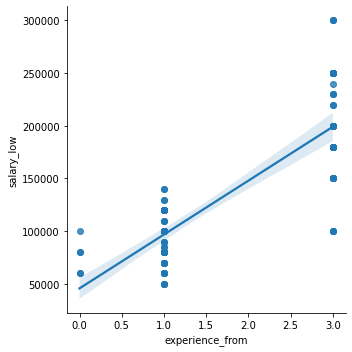

In [18]:
sns.lmplot(x="experience_from", y="salary_low", data=data)

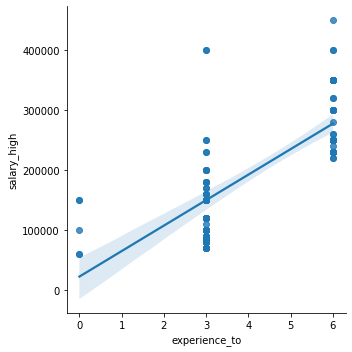

In [19]:
sns.lmplot(x="experience_to", y="salary_high", data=data)

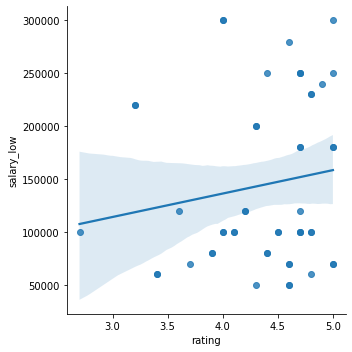

In [20]:
sns.lmplot(x="rating", y="salary_low", data=data)

In [21]:
data[data.skill == "Java"]

,name,salary,company_name,metro_station,description_list_items,company_address,rating,skills,description,salary_low,salary_high,experience_from,experience_to,skills_vector,skill
93,Cерверный программист / Java developer,NaN,DouDouGames,Алексеевская,"['Требуемый опыт работы', '', ':', '3–6 лет']","Москва, Алексеевская, проспект Мира, 102с12",4.8,"Git, Spring Framework, Java, PostgreSQL, Gamedev",Международная компания DouDouGames уже 6 лет р...,NaN,NaN,3.0,6.0,"[61, 507, 110, 363, 263]",Java
275,Middle/Senior Java developer - REMOTE,от 240 000 до 350 000 руб. на руки,Cartwheel,NaN,"['Требуемый опыт работы', '', ':', '3–6 лет']",NaN,4.9,"Git, Gradle, Деловая коммуникация, Оптимизация...","Мы - Cartwheel, американский стартап, производ...",240000.0,350000.0,3.0,6.0,"[61, 224, 556, 496]",Java
278,Разработчик Java (Программист Java) уровня Middle,NaN,Райт Скан,NaN,"['Требуемый опыт работы', '', ':', '1–3 года']","Москва, Малая Семеновская улица, 11/2с4",NaN,"SQL, RabbitMQ, Git",В IT компанию требуется Разработчик JAVA (можн...,NaN,NaN,1.0,3.0,"[53, 307, 61]",Java
320,Разработчик Java (Программист Java) уровня Middle,NaN,Райт Скан,NaN,"['Требуемый опыт работы', '', ':', '1–3 года']","Москва, Малая Семеновская улица, 11/2с4",NaN,"SQL, RabbitMQ, Git",В IT компанию требуется Разработчик JAVA (можн...,NaN,NaN,1.0,3.0,"[53, 307, 61]",Java
323,Java разработчик (relocate),NaN,SimpleTexting,NaN,"['Требуемый опыт работы', '', ':', '3–6 лет']",NaN,NaN,"Java, Spring Framework, MongoDB, Git, Unix","SimpleTexting расширяет команду разработки, мы...",NaN,NaN,3.0,6.0,"[110, 507, 271, 61, 137]",Java
350,Программист Java,NaN,CGM,NaN,"['Требуемый опыт работы', '', ':', '3–6 лет']",NaN,NaN,"Java, Git, Python, SQL, MongoDB, ORACLE, Perl,...",Обязанности: разработка новых модулей в облас...,NaN,NaN,3.0,6.0,"[110, 61, 207, 53, 271, 209, 113, 135, 192, 214]",Java
426,Cерверный программист / Java developer,NaN,DouDouGames,Алексеевская,"['Требуемый опыт работы', '', ':', '3–6 лет']","Москва, Алексеевская, проспект Мира, 102с12",4.8,"Git, Spring Framework, Java, PostgreSQL, Gamedev",Международная компания DouDouGames уже 6 лет р...,NaN,NaN,3.0,6.0,"[61, 507, 110, 363, 263]",Java


In [22]:
data[data.salary_low < 60000]

,name,salary,company_name,metro_station,description_list_items,company_address,rating,skills,description,salary_low,salary_high,experience_from,experience_to,skills_vector,skill
162,Программист-верстальщик сайтов (Wordpress/1C B...,от 50 000 до 150 000 руб. на руки,Smart SERM,NaN,"['Требуемый опыт работы', '', ':', '1–3 года']",NaN,4.6,"1С-Битрикс, Создание сайтов, Битрикс 24, Wordp...",Компания Smart Sell Group занимается комплексн...,50000.0,150000.0,1.0,3.0,"[353, 478, 348, 327, 542]",Wordpress
252,Junior frontend-разработчик (Интегратор),от 50 000 до 70 000 руб. на руки,DIGINETICA,NaN,"['Требуемый опыт работы', '', ':', '1–3 года']",NaN,4.3,"JavaScript, CSS, HTML, HTML5, Git, Vue, NPM","DIGINETICA — технологическая компания, основан...",50000.0,70000.0,1.0,3.0,"[350, 78, 83, 183, 61, 69, 48]",Интегратор
300,Программист С#,от 50 000 до 84 000 руб. на руки,ООО НКС,NaN,"['Требуемый опыт работы', '', ':', '1–3 года']",NaN,NaN,"SQL, MS SQL, Transact-SQL, C#, MS SQL Server",Задачи: Разработка и сопровождение модулей инф...,50000.0,84000.0,1.0,3.0,"[53, 218, 414, 4, 429]",С#
486,Программист-верстальщик сайтов (Wordpress/1C B...,от 50 000 до 150 000 руб. на руки,Smart SERM,NaN,"['Требуемый опыт работы', '', ':', '1–3 года']",NaN,4.6,"1С-Битрикс, Создание сайтов, Битрикс 24, Wordp...",Компания Smart Sell Group занимается комплексн...,50000.0,150000.0,1.0,3.0,"[353, 478, 348, 327, 542]",Wordpress


In [23]:
data.describe()

,rating,salary_low,salary_high,experience_from,experience_to
count,188.000000,128.000000,128.000000,444.000000,466.000000
mean,4.328191,144219.179688,202859.804688,1.898649,4.351931
std,0.537575,69648.618299,96316.132091,1.071316,1.767255
min,2.700000,50000.000000,60000.000000,0.000000,0.000000
25%,4.000000,88750.000000,117513.750000,1.000000,3.000000
50%,4.500000,120000.000000,210000.000000,1.000000,4.500000
75%,4.800000,200000.000000,250000.000000,3.000000,6.000000
max,5.000000,300000.000000,450000.000000,3.000000,6.000000


In [24]:
# model for a lower range of salary
categorical_cols = ["company_name", "metro_station", "skill"]

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
	('imputer', SimpleImputer(strategy='most_frequent')),
	('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
	transformers=[
		('cat', categorical_transformer, categorical_cols)
	])

model_low = XGBRegressor(n_estimators=2000, learning_rate=0.1, n_jobs=12)
pipeline_low = Pipeline(steps=[('preprocessor', preprocessor), ('model', model_low)])

In [25]:
train_data = data.copy()
train_data = train_data.loc[train_data["salary"].notna()]
print(train_data.shape)
y = train_data.pop("salary_low")
X = train_data

X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y,
                                                                random_state=0,
                                                                train_size=0.8,
                                                                test_size=0.2)


features = ["skill", "company_name", "metro_station", "rating", "experience_from", "experience_to", "skills_vector"]

X_train = X_train_full[features].copy()
X_valid = X_valid_full[features].copy()
print(X_train.shape)
print(X_valid.shape)


print(f"Features: {features}")

(128, 15)
(102, 7)
(26, 7)
Features: ['skill', 'company_name', 'metro_station', 'rating', 'experience_from', 'experience_to', 'skills_vector']


In [26]:
pipeline_low.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['company_name',
                                                   'metro_station',
                                                   'skill'])])),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsam...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=2000, n_jobs=12, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])

In [27]:
preds = pipeline_low.predict(X_valid)
print(preds)
score = mean_absolute_error(y_valid, preds)
print("Average MAE score:")
print(score)

[119999.77  179999.95  116677.12  100000.29  223699.42   69999.77
 120108.46  139999.77  181571.33  116677.12   80000.29  120108.46
 121391.12  223699.42   50000.137 219999.77  121391.12  199999.77
 112885.72  180000.5   249999.77  199999.77   80000.29   80000.29
 229999.77  248285.38 ]
Average MAE score:
25959.443359375


In [28]:
# model for a higher range of salary

model_high = XGBRegressor(n_estimators=2000, learning_rate=0.1, n_jobs=12)
pipeline_high = Pipeline(steps=[('preprocessor', preprocessor), ('model', model_high)])
train_data = data.copy()
train_data = train_data.loc[train_data["salary"].notna()]
print(train_data.shape)
y = train_data.pop("salary_high")
X = train_data

X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y,
                                                                random_state=0,
                                                                train_size=0.8,
                                                                test_size=0.2)


features = ["skill", "company_name", "metro_station", "rating", "experience_from", "experience_to", "skills_vector"]

X_train = X_train_full[features].copy()
X_valid = X_valid_full[features].copy()
print(X_train.shape)
print(X_valid.shape)


print(f"Features: {features}")

(128, 15)
(102, 7)
(26, 7)
Features: ['skill', 'company_name', 'metro_station', 'rating', 'experience_from', 'experience_to', 'skills_vector']


In [29]:
pipeline_high.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['company_name',
                                                   'metro_station',
                                                   'skill'])])),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsam...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=2000, n_jobs=12, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])

In [30]:
preds = pipeline_high.predict(X_valid)
print(preds[:10])
score = mean_absolute_error(y_valid, preds)
print("Average MAE score:")
print(score)

[119999.69 299999.7  135217.17 399999.7  228884.86 150000.22 199814.02
 249999.69 241678.62 135217.17]
Average MAE score:
37854.417668269234


In [31]:
X_valid.head(10)

,skill,company_name,metro_station,rating,experience_from,experience_to,skills_vector
240,1C,Айтон,NaN,NaN,1.0,3.0,"[542, 510, 607, 544]"
124,LARAVEL,ООО АЙТИ.СПЕЙС,NaN,NaN,3.0,6.0,"[363, 120, 39, 49, 61, 172, 121, 256]"
418,1C,Союзпластик,Перово,NaN,3.0,6.0,"[510, 542, 620, 472]"
280,Golang,ООО НЬЮЭРАМЕДИА,Деловой центр,4.0,1.0,3.0,"[232, 363, 150]"
45,.NET,ООО Инсап,NaN,4.5,1.0,3.0,"[629, 536, 80, 40, 305, 505, 454, 158, 603, 61..."
543,Yii 2 Framework,Smart SERM,NaN,4.6,1.0,3.0,"[353, 549, 505, 659, 470, 61, 39, 162]"
671,None,Астор,NaN,NaN,3.0,6.0,"[542, 622]"
473,R,LLC GFAGAMES,NaN,NaN,1.0,3.0,"[476, 195]"
336,None,Интернет-Агентство Jc,Деловой центр,2.7,1.0,3.0,"[162, 61, 114, 325, 49, 380, 281, 509, 390]"
43,1C,Союзпластик,Перово,NaN,3.0,6.0,"[510, 542, 620, 472]"
